# Introduction

While perusing through the book "Elements of Statistical Learning," I ran across the chapter on methods of best subset selection. The goal of these is to find the "best" subset of features in a dataset fitted to a model to predict a target value or values. For some reason, I found myself so intrigued that I wanted to implement each of them myself. 

With the Titanic and California Housing Prices datasets used for toy classification and regression tasks, I will implement and explain each of the four procedures: leaps and bounds, forward and backward stagewise selection, and forward stagewise regression. The first three procedures will be written to train either a classification model with logistic regression, or a linear regression model. For consistency, each of these will train a logistic regression model. The final one, forward stagewise regression, will not require any learning algorithm as it attempts to find values of coefficients like a standard linear model does.

## Imports, Warnings

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    
    path1 = Path('../input/titanic')
    path2 = Path('../input/california-housing-prices')
else:
    path1 = Path('titanic')
    path2 = Path('california-housing-prices')
    if not path1.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path1))
        zipfile.ZipFile(f'{path1}.zip').extractall(path1)
        
    if not path2.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path2))
        zipfile.ZipFile(f'{path2}.zip').extractall(path2)

In [2]:
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings
import itertools
import statsmodels.api as sm

warnings.filterwarnings('ignore')
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import f1_score, log_loss, precision_score, recall_score, roc_auc_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error

from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Classification

## Cleaning Titanic data

Before implementing any model, I will first view and clean the data being used for classification purposes. The [Titanic dataset](https://www.kaggle.com/competitions/titanic) is a simple dataset found on Kaggle, and it contains information on Titanic passengers as well as a binary variable of whether or not that passenger survived. The goal is to find a model that best predicts which passengers survived the sinking of the Titanic or not based on characteristics like the fare they paid, whether they were male or female, etc. 

For simplicity, I will perform the same cleaning that Jeremy Howard did for [Lesson 5](https://youtu.be/_rXzeWq4C6w?si=KDLqNhgIsdgPdgoG) of his course "Practical Deep Learning for Coders." NA values are filled in with their respective mode value, the Fare variable is 
log-transformed to make it more normal, and different columns are separted into OHC columns or standardized columns, which will go into the preprocessing scheme used by the trained logistic models.

In [4]:
df = pd.read_csv(path1/'train.csv')
print(df.shape)
df.head(10)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)

<AxesSubplot:>

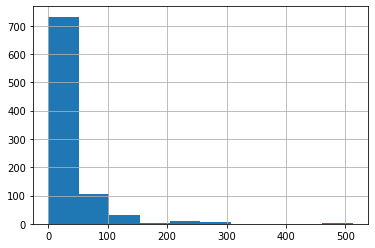

In [6]:
df.Fare.hist()

In [7]:
df['LogFare'] = np.log(df['Fare']+1)

<AxesSubplot:>

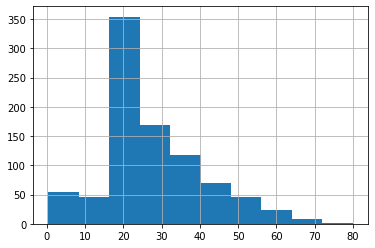

In [8]:
df.Age.hist()

In [9]:
ohc_columns=["Sex","Pclass","Embarked"]
scale_cols = ['Age', 'LogFare']
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare',"Sex","Pclass","Embarked"]
y_col = ['Survived']

y = df[y_col]
X = df[indep_cols]

model_data = df[y_col + indep_cols]
model_data.head()

,Survived,Age,SibSp,Parch,LogFare,Sex,Pclass,Embarked
0,0,22.0,1,0,2.110213,male,3,S
1,1,38.0,1,0,4.280593,female,1,C
2,1,26.0,0,0,2.188856,female,3,S
3,1,35.0,1,0,3.990834,female,1,S
4,0,35.0,0,0,2.202765,male,3,S


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify = y,
                                                          test_size=0.2, random_state=42)

In [11]:
features_li = X.columns

## Setting up a Logistic Model

Next I will create a function that trains a standard-issue logistic regression model, just to be able to repeat the same training process of splitting the dataset, preprocessing, model fitting, and metric evaluation. Instead of one, I like to evaluate on multiple classification metrics, including probabilistic ones like Cohen's Kappa, to get a less singular view of model performance. To start, I want to train a baseline logistic regression model with all available features to establish whether each new model is an improvement or not. Also, the same training and validation set will be used for all trained models so as to not have any spurious results.

### Baseline

In [12]:
def train_log_model(train_X, valid_X, train_y, valid_y, model_id, features, preprocess = True,
                    ohc_cols = ['Sex', 'Pclass', 'Embarked'], std_cols = ['Age', 'LogFare']):    
    '''
    Goal: Train a logistic regression model in sci-kit learn with preprocessing,
          fitting, and metric evaluation done, saving results to a dataframe
           
    Arguments:
        train_X,valid_X,train_y,valid_y: pandas.DataFrame, dataset to test models 
        model_id: str, used to name the model itself (i.e. 'baseline')
        features: list, contains names of features
        preprocess: boolean, set to preprocess data if necessary
        ohc_cols: list, contains names for columns that need OHC
        std_cols: list, contains names for columns that need standardizing
    
    Returns:
        results: pandas.DataFrame, contains values for all classification metrics used
                 (log-loss, precision/recall, ROC-AUC, etc.)
    '''

    if preprocess:
        # Define the column transformer
        # OHC: OneHotEncoder, SS: StandardScaler
        preprocessor = ColumnTransformer(
            transformers=[
                ('OHC', OneHotEncoder(), ohc_cols),
                ('SS', StandardScaler(), std_cols)
            ],
            remainder='passthrough'
        )

        # Create the Logistic Regression model
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression())
        ])

        # Fit the model on the training data
        model.fit(train_X, train_y)
    else:
        model = LogisticRegression()
        model.fit(train_X, train_y)

    # Make predictions on the validation set
    y_pred = model.predict(valid_X)

    # Evaluate the model on suite of classification metrics
    conf_matrix = confusion_matrix(valid_y, y_pred)
    balanced_acc = balanced_accuracy_score(valid_y, y_pred)
    kappa = cohen_kappa_score(valid_y, y_pred)
    f1 = f1_score(valid_y, y_pred)
    logloss = log_loss(valid_y, model.predict_proba(valid_X))
    precision = precision_score(valid_y, y_pred)
    recall = recall_score(valid_y, y_pred)
    roc_auc = roc_auc_score(valid_y, model.predict_proba(valid_X)[:, 1])
    
    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Features': [features],
        'Balanced Accuracy': [balanced_acc],
        'Log Loss': [logloss],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc],
        'Cohen Kappa Score': [kappa]
    })
    
    # Old Code: Confusion Matrix
    '''
    classes= ['0','1']
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", 
                cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix: {model_id}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    '''
    # Return the results
    return results


In [13]:
# Baseline Model
baseline_model = train_log_model(X_train, X_valid, y_train, y_valid, model_id = 'Baseline Model', features = features_li)
baseline_model

,Features,Balanced Accuracy,Log Loss,Precision,Recall,F1 Score,ROC AUC,Cohen Kappa Score
0,"Index(['Age', 'SibSp', 'Parch', 'LogFare', 'Se...",0.776943,0.467048,0.770492,0.681159,0.723077,0.838142,0.566119


### "Leaps and Bounds"

The first subset selection method is the simplest one, and goes by the name of the "Leaps and Bounds" Procedure. Suppose a dataset has $n$ features available to train a model with. "Leaps and bounds" will instead generate every possible combination of $n-1$  features, and train a model for each combination. For each number of $k$ variables where $1\leq k <n$, the model of $k$ variables is selected to be the "best" if it performs best on the metric used to compare each model's performance. That metric is an argument for the function that executes the procedure, and finds the matching column for the value in the dataframe of metrics that each model is evaluated on when it is trained.

While I included multiple metrics to evaluate all logistic models, leaps and bounds sort of forces one metric to be selected to evaluate which model performs the best. For this particular task, I settled on log loss as the single best metric. The baseline model for the Titanic Dataset has a log los of approximately 0.467. This is the value that each model iteration should be trying to beat. 

In [14]:
def leaps_and_bounds(train_X, valid_X, train_y, valid_y, target, 
                     ohc_columns, scale_cols, comp_metric, reg_task = True):
    """
    Goal: Test all combinations of predictors in a dataset for a classification/regression task
    
    Arguments:
        train_X,valid_X,train_y,valid_y: pandas.DataFrame, dataset to test models
        target: pandas.Series, contains target values for task
        ohc_columns: list, contains names of predictors to be OHC
        scale_cols: list, contains names of predictors to be standardized
        comp_metric: str, contains name of metric to compare all model iterations with to
                     determine the best for each number k of predictors
        reg_task: boolean, chooses model to fit depending on classification/regression task
    Returns:
        results_df: pandas.DataFrame, contains results of testing for 
                    all combinations of predictors
    """
    # Generate features of dataset, initialize results DataFrame
    feature_names = [i for i in train_X.columns if i != target]
    results_df = pd.DataFrame()

    # For each number of possible features, k
    for k in range(1, len(feature_names)):
        subset_df = pd.DataFrame()
        
        # Generate all possible combinations of k predictors
        combinations = itertools.combinations(feature_names, k)

        # For each valid combination of k features
        for subset in combinations:
            # Set columns to be OHC or standardized in model training function
            subset_features = list(subset)
            subset_ohc = [i for i in list(subset) if i in ohc_columns]
            subset_scale = [i for i in list(subset) if i in scale_cols]
            
            # Set X and y dfs
            data_X_train = train_X[subset_features]
            data_X_valid = valid_X[subset_features]
            
            model_name = str(k) + ' Variable Model'
            # Train model with combination of features
            if reg_task:
                model_results = train_lin_reg(data_X_train, data_X_valid, train_y, valid_y,
                                              model_name, features = subset_features,
                                            ohc_cols = subset_ohc, std_cols =subset_scale)
            else:
                model_results = train_log_model(data_X_train, data_X_valid, train_y, valid_y,
                                                model_name, features = subset_features,
                                            ohc_cols = subset_ohc, std_cols =subset_scale)
            
            # Add to results the number of features and model training results for each iteration
            model_results['Num_Features'] = len(model_results.Features[0])
            subset_df = subset_df.append(model_results, ignore_index=True)

        # Find the row with the maximum value of the comparison metric
        min_value_index = subset_df[comp_metric].argmin()
        
        # Create a new column 'Best' and set it to 1 for the row with the min value, 
        # and 0 otherwise for best model in each subset of features by number
        subset_df['Best'] = 0
        subset_df.loc[min_value_index, 'Best'] = 1

        results_df = results_df.append(subset_df)

    return results_df

In [15]:
y_target = 'Survived'
ohc_cols=["Sex","Pclass","Embarked",'Parch']
scale_cols = ['Age', 'LogFare']
metric = 'Log Loss'
regression_task = False

leaps_bounds_results = leaps_and_bounds(X_train, X_valid, y_train, y_valid, y_target, ohc_cols, 
                                        scale_cols, metric, regression_task)
leaps_bounds_results

,Features,Balanced Accuracy,Log Loss,Precision,Recall,F1 Score,ROC AUC,Cohen Kappa Score,Num_Features,Best
0,[Age],0.500000,0.666845,0.000000,0.000000,0.000000,0.518050,0.000000,1,0
1,[SibSp],0.500000,0.665075,0.000000,0.000000,0.000000,0.472003,0.000000,1,0
2,[Parch],0.552174,0.660685,0.488372,0.304348,0.375000,0.558630,0.112229,1,0
3,[LogFare],0.568511,0.650969,0.523810,0.318841,0.396396,0.647299,0.147801,1,0
4,[Sex],0.753360,0.529557,0.737705,0.652174,0.692308,0.753360,0.517910,1,1
...,...,...,...,...,...,...,...,...,...,...
2,"[Age, SibSp, Parch, LogFare, Pclass, Embarked]",0.661858,0.607707,0.660000,0.478261,0.554622,0.709618,0.341226,6,0
3,"[Age, SibSp, Parch, Sex, Pclass, Embarked]",0.786034,0.459518,0.796610,0.681159,0.734375,0.848682,0.587949,6,0
4,"[Age, SibSp, LogFare, Sex, Pclass, Embarked]",0.774242,0.467122,0.779661,0.666667,0.718750,0.840514,0.563710,6,0
5,"[Age, Parch, LogFare, Sex, Pclass, Embarked]",0.746970,0.480828,0.707692,0.666667,0.686567,0.828920,0.499334,6,0


In [16]:
%timeit leaps_and_bounds(X_train, X_valid, y_train, y_valid, y_target, ohc_cols,scale_cols, metric, regression_task)

7.53 s ± 91.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
leaps_bounds_results['Num_Features'].value_counts(sort=True)

3    35
4    35
2    21
5    21
1     7
6     7
Name: Num_Features, dtype: int64

Within the procedure, for each model with $k$ features, all others models with $k$ features are compared along the metric. In the case of log loss, each model with $k$ features is compared to find the model with the lowest value. That model is then marked in the "Best" column. To visualize the performance of the procedure, we plot the log loss of each model iteration with its unique set of predictors, with the lowest one for models of each number of features colored in blue. In this example, five features of age, number of siblings or spouses on board, number of parents or children on board, sex, and ticket class, make for the model with lowest overall log loss. Overall, only a handful of models with between 4 and 6 features beat the performance of the baseline model that uses all 7 features.

In total, for 7 features, 126 total models were trained and evaluated. In the general case, for $n$ features, $\sum_{{r=1}}^{{n}} \binom{n}{r}$ different models are trained. The fact that this is a greedy procedure serves as the main drawback of leaps and bounds: in high dimensions it is too computationally expensive to be of use. With 7 features, $7.13 s \pm 200 ms$ per loop is the execution time. However, this does not scale linearly with respect to the number of features since more combinations of features need to be found.

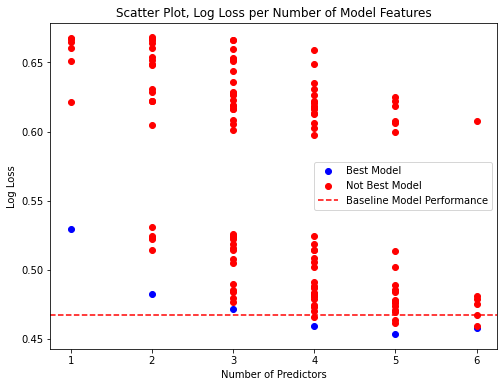

In [18]:
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(leaps_bounds_results[leaps_bounds_results.Best == 1]['Num_Features'], 
            leaps_bounds_results[leaps_bounds_results.Best == 1]['Log Loss'], 
            color='blue', label='Best Model')
plt.scatter(leaps_bounds_results[leaps_bounds_results.Best == 0]['Num_Features'], 
            leaps_bounds_results[leaps_bounds_results.Best == 0]['Log Loss'],
            color='red', label='Not Best Model')
plt.axhline(y=baseline_model['Log Loss'][0], color='r', linestyle='--', label='Baseline Model Performance')


# Set plot labels and title
plt.xlabel('Number of Predictors')
plt.ylabel('Log Loss')
plt.title('Scatter Plot, Log Loss per Number of Model Features')

# Set x-axis ticks to show values from 1 to 6
plt.xticks(np.arange(1, 7))

# Add legend
plt.legend()

# Show the plot
plt.show()

In [19]:
leaps_bounds_results[leaps_bounds_results.Best == 1].reset_index(drop=True)

,Features,Balanced Accuracy,Log Loss,Precision,Recall,F1 Score,ROC AUC,Cohen Kappa Score,Num_Features,Best
0,[Sex],0.753360,0.529557,0.737705,0.652174,0.692308,0.753360,0.517910,1,1
1,"[Sex, Pclass]",0.753360,0.482699,0.737705,0.652174,0.692308,0.821673,0.517910,2,1
2,"[SibSp, Sex, Pclass]",0.776087,0.471687,0.803571,0.652174,0.720000,0.825758,0.572267,3,1
3,"[Age, SibSp, Sex, Pclass]",0.776943,0.458971,0.770492,0.681159,0.723077,0.845784,0.566119,4,1
4,"[Age, SibSp, Parch, Sex, Pclass]",0.788735,0.453449,0.786885,0.695652,0.738462,0.851910,0.590224,5,1
5,"[Age, SibSp, Parch, LogFare, Sex, Pclass]",0.793281,0.457613,0.800000,0.695652,0.744186,0.848814,0.601175,6,1


### Stepwise Selection: Foward & Backward

The next two methods are the stepwise selection methods. Both are less greedy than the leaps and bounds procedure, but still require iterating through all available features; it's just done in a different way. 

For forward stepwise selection, we start by fitting an initial model with an intercept only. While Sci-Kit Learn fits models with or without intercepts, we'll be using Statsmodels Logit and OLS functions to train multiple models as part of the stepwise procedure. Therefore, an intercept column is added to the dataset before being used to train the first model. However, this first model will not be used to compare successive models, as features will be added to improve performance. The baseline model with 0.467 log loss on the validation set will still be used to compare the one final model outputted by the forward stepwise procedure.



In [20]:
# Set intercept to model data, train baseline-model on intercept only
model_data['Intercept'] = 1

frw_step_X = np.array(model_data['Intercept']).reshape(-1,1)
frw_step_y = model_data['Survived']


frw_X_train, frw_X_valid, frw_y_train, frw_y_valid = train_test_split(np.array(frw_step_X).reshape(-1,1), 
                                                                      frw_step_y,
                                                                      stratify = frw_step_y,
                                                          test_size=0.2, random_state=42)

train_log_model(frw_X_train, frw_X_valid, frw_y_train, frw_y_valid,
                'Intercept Only', features = ['Intercept'], preprocess=False)

,Features,Balanced Accuracy,Log Loss,Precision,Recall,F1 Score,ROC AUC,Cohen Kappa Score
0,[Intercept],0.5,0.66669,0.0,0.0,0.0,0.5,0.0


In [21]:
y = model_data['Survived']
X = model_data.drop(['Survived','Intercept'],axis=1)
X_ohc = pd.get_dummies(X, columns=ohc_columns)

After the initial model, we move on to adding individual features. For each feature, a new model is fit with the feature added on, and the model's p-values for all features are returned. The criteria for adding features to a final model is if it 1. contains the lowest p-value of all features, and 2. its p-value is lower than a set threshold. For instance, the SOP p-value thrown around is $ p < 0.05 $. For simplicity, I will use $0.05$ as the threshold to include features in a final model given their p-value.

Disclaimer: This code is adapted from a [post on StackExchange](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-a-forward-selection-stepwise-regression-algorithm), and I separated the two procedures into individual functions for purposes of clarity.

In [22]:
def forward_stepwise_selection(train_X,valid_X,train_y,valid_y, initial_list=[],
                               threshold_in=0.05, verbose=True, reg_task = True):
    """ 
    Goal: Perform a forward-stepwise feature selection 
          based on p-value from statsmodels.api.Logit
    
    Arguments:
        train_X,valid_X,train_y,valid_y: pandas.DataFrame, dataset to test models 
        initial_list: list, contains features to start with (column names of X)
        threshold_in: float, used to include features,
                      including a feature if feature's p-value < threshold_in
        verbose: boolean, set to print the sequence of inclusions and exclusions
        reg_task: boolean, chooses model to fit depending on classification/regression task
    Returns: 
        final_model_df: pandas.DataFrame, contains results of model
        
        
    Note: Code adapted from code commented on a post found on Data Science StackExchange,
    See https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-a-forward-selection-stepwise-regression-algorithm
    
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details on forward-stepwise selection
    """
    included = list(initial_list)
    while True:
        changed=False
        
        # Find candidate features, creates series for feature's p-values
        excluded = list(set(train_X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        
        # Forward Step: For each candidate feature
        for new_column in excluded:            
            step_features = included+[new_column]
            
            # Sets dataframe to only include variables (from included list and the candidate feature)
            X_stepwise = pd.DataFrame(train_X[step_features])
            X_df_forw =sm.add_constant(X_stepwise)
            
            # Test statsmodel Logit/OLS on candidate features plus initial features 
            if reg_task:
                model = sm.OLS(train_y, X_df_forw).fit(disp=0)
            else:
                model = sm.Logit(train_y, X_df_forw).fit(disp=0)
            
            #print(X_df_forw.columns)
            # Returns pvalues for candidate features
            new_pval[new_column] = model.pvalues[new_column]
        
        # Finds the minimum p_values, adds to final list of features if < threshold 
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        
        # If no more features to add, break loop
        if not changed:
            break
        
    print('Included Features:', included)
    
    # With final features, train final logistic model
    train_X_final = train_X[included]
    valid_X_final = valid_X[included]
    final_model_df = train_log_model(train_X,valid_X,train_y,valid_y, 'Stepwise Selection Model',
                                     features = included, preprocess=False)
    return final_model_df

In [23]:
X_train_ohc = pd.get_dummies(X_train, columns=ohc_columns)
X_valid_ohc = pd.get_dummies(X_valid, columns=ohc_columns)

In [24]:
result = forward_stepwise_selection(X_train_ohc, X_valid_ohc, y_train, y_valid, reg_task=False)
result

Add  Sex_male                       with p-value 6.12497e-42
Add  Pclass_3                       with p-value 5.74201e-14
Add  Embarked_S                     with p-value 0.000462871
Add  Age                            with p-value 0.000619358
Add  Pclass_2                       with p-value 0.00066761
Add  SibSp                          with p-value 0.0284601
Add  LogFare                        with p-value 0.0247913
Included Features: ['Sex_male', 'Pclass_3', 'Embarked_S', 'Age', 'Pclass_2', 'SibSp', 'LogFare']


,Features,Balanced Accuracy,Log Loss,Precision,Recall,F1 Score,ROC AUC,Cohen Kappa Score
0,"[Sex_male, Pclass_3, Embarked_S, Age, Pclass_2...",0.776943,0.46708,0.770492,0.681159,0.723077,0.838011,0.566119


Backward stepwise selection goes in the opposite direction. Instead of starting with no features and building a model successively, the backward stepwise procedure starts with a model containing all features, but removes features in the same way. For the highest p-value of the model's features, it is removed if it exceeds the set threshold (still $p<0.05$). This repeats until no feature can be removed.

In [25]:
def backward_stepwise_selection(train_X,valid_X,train_y,valid_y,
                                threshold_out = 0.05, verbose=True, reg_task = True):
    """ 
    Goal: Perform a backward-stepwise feature selection 
          based on p-value from statsmodels.api.Logit
    
    Arguments:
        train_X,valid_X,train_y,valid_y: pandas.DataFrame, dataset to test models 
        initial_list: list, contains features to start with (column names of X)
        threshold_out: float, used to exclude features,
                      excluding a feature if feature's p-value > threshold_out
        verbose: boolean, set to print the sequence of inclusions and exclusions
        reg_task: boolean, chooses model to fit depending on classification/regression task
    Returns: 
        final_model_df: pandas.DataFrame, contains results of final model
        
        
    Note: Code adapted from code commented on a post found on Data Science StackExchange,
    See https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-a-forward-selection-stepwise-regression-algorithm
    
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details on stepwise regression
    """
    
    # Set initial model to include all features in a dataframe
    included = list(train_X.columns)
    while True:
        changed=False
        
        # Builds initial model with all features
        X_df_back = sm.add_constant(train_X[included])
        if reg_task:
            model = sm.OLS(train_y, X_df_back).fit(maxiter = 1000)
        else:
            model = sm.Logit(train_y, X_df_back).fit(maxiter = 1000)
        
        # Use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        
        # Take highest p-value, remove feature with p-value if higher than threshold
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))

        # If no p-value removed, break loop
        if not changed:
            break
        
    print('Included Features:', included)
    
    # Train final model with presumably less features than initial dataframe
    train_X_final = train_X[included]
    valid_X_final = valid_X[included]
    final_model_df = train_log_model(train_X_final, valid_X_final, train_y, valid_y,
                                     'Stepwise Selection Model', features = included,
                                     preprocess=False)
    return final_model_df

In [26]:
result = backward_stepwise_selection(X_train_ohc, X_valid_ohc, y_train, y_valid, reg_task = False)
result

Optimization terminated successfully.
         Current function value: 0.432576
         Iterations 7
Drop Embarked_C                     with p-value 1.0
Optimization terminated successfully.
         Current function value: 0.432576
         Iterations 6
Drop Embarked_Q                     with p-value 0.468293
Optimization terminated successfully.
         Current function value: 0.432944
         Iterations 10
Drop Parch                          with p-value 0.0608419
Optimization terminated successfully.
         Current function value: 0.434349
         Iterations 6
Drop Pclass_2                       with p-value 1.0
Optimization terminated successfully.
         Current function value: 0.434349
         Iterations 6
Drop Pclass_1                       with p-value 0.0568409
Optimization terminated successfully.
         Current function value: 0.436858
         Iterations 6
Included Features: ['Age', 'SibSp', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_3', 'Embarked_S']


,Features,Balanced Accuracy,Log Loss,Precision,Recall,F1 Score,ROC AUC,Cohen Kappa Score
0,"[Age, SibSp, LogFare, Sex_female, Sex_male, Pc...",0.778788,0.466302,0.793103,0.666667,0.724409,0.842622,0.574649


Both models edge are similar to the baseline model in terms of log loss, with the . However, a couple of things are of note with regards to these procedures. One, the data is inputted into the function already preprocessed; which means two, the one-hot encoded variables are treated as their own features during both procedures. At the end result, different categories for sex and class of ticket were selected while other categories in the same variable were not. It is not clear if that is to be intended with regards to these procedures, but selectively including or excluding categories of a single feature based on their p-values seems dubious at face value, and appears like a good way to overfit a model if done improperly.

# Regression

## Cleaning Housing Prices Data

Moving onto regression, I chose to use the California Housing Prices Dataset to implement the final method: forwad stagewise regression. Before that, however, a simple cleaning procedure is needed to prep the data. Nothing fancy is done, just similar transformations to those done on the Titanic dataset. After that, a simple function to train and evaluate a linear regression model is created to test a baseline model.

In [27]:
df = pd.read_csv(path2/'housing.csv')
print(df.shape)
df.head(10)

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


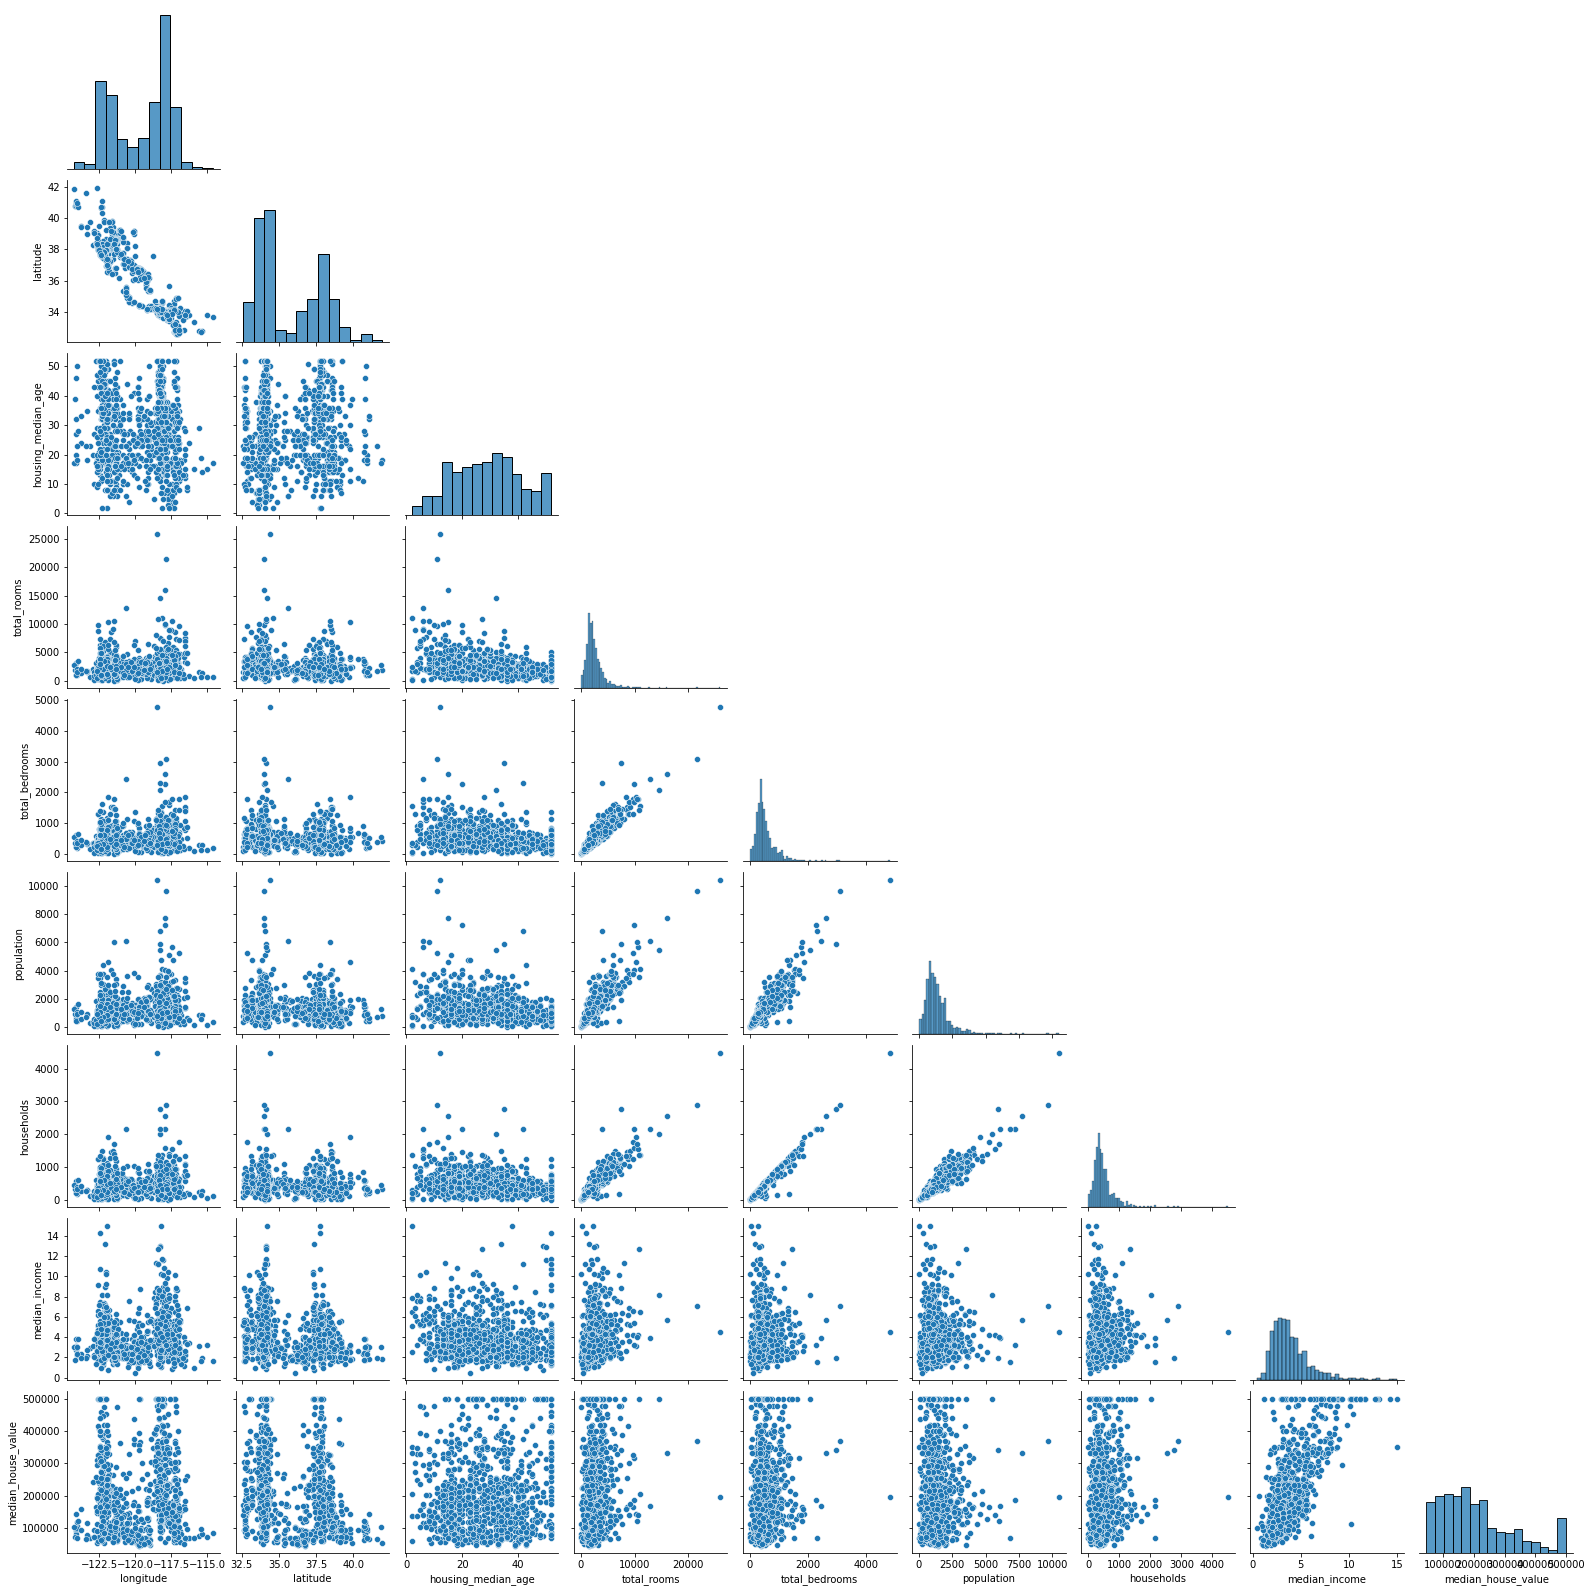

In [28]:
sns.pairplot(df.sample(1000), corner=True)

<AxesSubplot:>

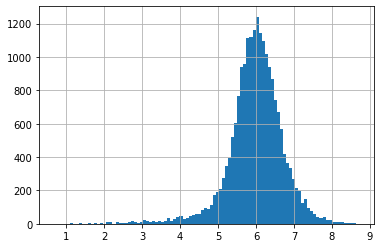

In [29]:
np.log1p(df.households).hist(bins=100)

In [30]:
#df.median_income = df.median_income * 10000
df.median_house_value = df.median_house_value / 10000

In [31]:
medians = df.median().iloc[0]
df_filled = df.fillna(medians)

In [32]:
df_filled['log_total_rooms']= np.log(df_filled['total_rooms'] +1)
df_filled['log_population'] = np.log(df_filled['population']+1)
df_filled['log_median_income'] = np.log(df_filled['median_income']+1)
df_filled['log_households'] = np.log(df_filled['households']+1)

In [33]:
ohc_columns=["ocean_proximity"]
scale_cols = ['latitude','longitude', 'housing_median_age','log_total_rooms',
             'total_bedrooms','log_population','log_median_income','log_households']

indep_cols = [i for i in ohc_columns + scale_cols if i != 'median_house_value']
y_col = ['median_house_value']

y_reg = df_filled[y_col]
X_reg = df_filled[indep_cols]

model_data = df_filled[y_col + indep_cols]
model_data.head()

,median_house_value,ocean_proximity,latitude,longitude,housing_median_age,log_total_rooms,total_bedrooms,log_population,log_median_income,log_households
0,45.26,NEAR BAY,37.88,-122.23,41.0,6.781058,129.0,5.777652,2.232720,4.844187
1,35.85,NEAR BAY,37.86,-122.22,21.0,8.867850,1106.0,7.784057,2.230165,7.037906
2,35.21,NEAR BAY,37.85,-122.24,52.0,7.291656,190.0,6.208590,2.111110,5.181784
3,34.13,NEAR BAY,37.85,-122.25,52.0,7.150701,235.0,6.326149,1.893579,5.393628
4,34.22,NEAR BAY,37.85,-122.25,52.0,7.395108,280.0,6.338594,1.578195,5.560682


In [34]:
X_train_reg, X_valid_reg, y_train_reg, y_valid_reg = train_test_split(X_reg, y_reg,
                                                          test_size=0.2, random_state=42)

## Set Up Linear Regression

In [35]:
def train_lin_reg(train_X,valid_X,train_y,valid_y, model_id, features, preprocess = True,
                  ohc_cols = ohc_columns, std_cols = scale_cols):    
    
    '''
    Goal: Train a linear regression model in sci-kit learn with preprocessing,
          fitting, and metric evaluation done, saving results to a dataframe
           
    Arguments:
        train_X,valid_X,train_y,valid_y: pandas.DataFrame, dataset to test models 
        model_id: str, used to name the model itself (i.e. 'baseline')
        features: list, contains names of features
        preprocess: boolean, set to preprocess data if necessary
        ohc_cols: list, contains names for columns that need OHC
        std_cols: list, contains names for columns that need standardizing
    
    Returns:
        results: pandas.DataFrame, contains values for all regression metrics used
                 (MAE, MSE, etc.)
    '''

    if preprocess:
        # Define the column transformer
        # OHC: OneHotEncoder, SS: StandardScaler
        preprocessor = ColumnTransformer(
            transformers=[
                ('OHC', OneHotEncoder(), ohc_cols),
                ('SS', StandardScaler(), std_cols)
            ],
            remainder='passthrough'
        )

        # Create the Logistic Regression model
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LinearRegression())
        ])

        # Fit the model on the training data
        model.fit(train_X, train_y)
    else:
        model = LinearRegression()
        model.fit(train_X, train_y)

    # Make predictions on the validation set
    y_pred = model.predict(valid_X)

    # Evaluate the model on suite of metrics
    mse = mean_squared_error(valid_y, y_pred)
    mae = mean_absolute_error(valid_y, y_pred)
    mape = mean_absolute_percentage_error(valid_y, y_pred)
    med_ae = median_absolute_error(valid_y, y_pred)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Features': [features],
        'MSE': [mse],
        'MAE': [mae],
        'MAPE': [mape],
        'MedAE': [med_ae]
    })
    
    # Return the results
    return results

In [36]:
# Baseline Model
baseline_model = train_lin_reg(X_train_reg, X_valid_reg, y_train_reg, y_valid_reg,
                               'Baseline Regression Model', features = X_train_reg.columns)
baseline_model

,Features,MSE,MAE,MAPE,MedAE
0,"Index(['ocean_proximity', 'latitude', 'longitu...",49.923029,5.274828,0.31856,4.189699


## Forward Stagewise Regression

A good way to think of forward stagewise regression is as a form of gradient descent that can ignore specific features. Only one "model" is trained, though a sci-kit or statsmodels Linear Regression model is not necessary. Instead of actual gradient descent, the coefficients are changed via calcualting the residuals of $y$ and $wx$ and finding the features most correlated with those residuals. The coefficient for the feature most correlated with the residuals, positive or negative, is updated by adding the product of the learning rate $\alpha$ and the sign of its correlation to the residuals. 

The procedure can stop however, if the maximum correlations falls below a particular threshold. By default, I've set it to 0.3 so that any coefficient updates are done due to a moderate correlation with the residuals at minimum. With the final coefficients, we calculate a simple $wx+b$ to attain predictions for the validation set, and evaluate the forward stagewise regression model using them as well as the ground-truth values.

In [37]:
def forward_stagewise_regression(X, y, threshold=0.3, max_iterations=100, learning_rate=0.01,
                                test = False):
    """
    Goal: Perform forward stagewise regression to select features and estimate coefficients.

    Arguments:
        X: numpy.ndarray, Feature matrix with shape (n_samples, n_features).
        y: numpy.ndarray, Target vector with shape (n_samples,).
        threshold: float, The maximum correlation threshold to continue iterations.
        max_iterations: int, The maximum number of iterations.
        learning_rate: float, The step size for updating coefficients.

    Returns:
        coefficients: numpy.ndarray, Estimated coefficients for selected features.
        intercept: float, Intercept term in the regression model.
    """
    if not isinstance(y, np.ndarray):
        y = y.values.reshape(1,-1)[0]
    
    # Add a column of ones for the intercept term
    n, p = X.shape
    intercept = np.ones((n, 1))
    X = np.hstack((intercept, X))

    # Initialize coefficients to zeros, iteration counter
    coefficients = np.zeros(p + 1)
    iterations = 0

    # Stagewise regression loop
    while iterations < max_iterations:
        # Calculate residuals
        residuals = y - np.dot(X, coefficients)

        # Calculate correlations between features and residuals
        correlations = np.dot(X.T, residuals)

        # Find the index and value of the maximum absolute correlation
        max_correlation = np.max(np.abs(correlations))
        if max_correlation < threshold:
            break

        idx = np.argmax(np.abs(correlations))
        
        # Update the coefficient using the specified learning rate
        coefficients[idx] += learning_rate * np.sign(correlations[idx])

        # Testing code
        if test:
            if iterations % 10 == 0:
                print(coefficients)
            
        # Increment the iteration counter
        iterations += 1

    # Print the number of iterations performed
    print('Iterations:', iterations)

    # Return the estimated coefficients (excluding the intercept) and intercept
    return coefficients[1:], coefficients[0]

In [38]:
# Example usage:
# Assuming 'X' is your feature matrix and 'y' is your target variable
# Make sure they are NumPy arrays or Pandas DataFrames/Series

# Example Data
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y = np.array([6, 15, 24])

coefficients, intercept = forward_stagewise_regression(X, y, max_iterations=1000, test=True)

print("Coefficients:", coefficients)
print("Intercept:", intercept)

[0.   0.   0.   0.01]
[0.   0.   0.   0.11]
[0.   0.   0.   0.21]
[0.   0.   0.   0.31]
[0.   0.   0.   0.41]
[0.   0.   0.   0.51]
[0.   0.   0.   0.61]
[0.   0.   0.   0.71]
[0.   0.   0.   0.81]
[0.   0.   0.   0.91]
[0.   0.   0.   1.01]
[0.   0.   0.   1.11]
[0.   0.   0.   1.21]
[0.   0.   0.   1.31]
[0.   0.   0.   1.41]
[0.   0.   0.   1.51]
[0.   0.   0.   1.61]
[0.   0.   0.   1.71]
[0.   0.   0.   1.81]
[0.   0.   0.   1.91]
[0.   0.   0.   2.01]
[0.   0.   0.   2.11]
[0.   0.   0.   2.21]
[0.   0.   0.   2.31]
[0.   0.   0.   2.41]
[0.   0.   0.   2.51]
[0.   0.1  0.   2.51]
[0.   0.16 0.   2.47]
[0.   0.22 0.   2.43]
[0.   0.27 0.   2.38]
[0.   0.33 0.   2.34]
[0.   0.39 0.   2.3 ]
[0.   0.45 0.   2.26]
[0.   0.51 0.   2.22]
[0.   0.56 0.   2.17]
[0.   0.62 0.   2.13]
[0.   0.68 0.   2.09]
[0.   0.74 0.   2.05]
[0.   0.8  0.   2.01]
[0.   0.85 0.   1.96]
[0.   0.91 0.   1.92]
[0.   0.97 0.   1.88]
[0.   1.03 0.   1.84]
[0.   1.09 0.   1.8 ]
[0.   1.14 0.   1.75]
[0.   1.2 

In [39]:
def forw_stage_reg(train_X,valid_X,train_y,valid_y, model_id, features,
                   num_iters=1000,lr=1,
                   ohc_cols=ohc_columns, std_cols=scale_cols):
    """
    Goal: Perform forward stagewise regression on a given dataset for regression tasks.

    Arguments:
        train_X,valid_X,train_y,valid_y: pandas.DataFrame, dataset to test models 
        model_id: str, Identifier for the model.
        num_iters: int, Number of iterations for the forward stagewise regression.
        lr: float, Learning rate for updating coefficients during regression.
        ohc_cols: list, List of columns to be one-hot encoded.
        std_cols: list, List of columns to be standardized.

    Returns:
        results: pd.DataFrame, DataFrame containing regression evaluation metrics.
    """

    # Preprocess the training set using one-hot encoding and standard scaling
    preprocessor = ColumnTransformer(
        transformers=[
            ('OHC', OneHotEncoder(), ohc_cols),
            ('SS', StandardScaler(), std_cols)
        ],
        remainder='passthrough'
    )
    train_X_tsfmd = preprocessor.fit_transform(train_X)

    # Perform forward stagewise regression on the preprocessed training set
    coefficients, intercept = forward_stagewise_regression(train_X_tsfmd, train_y,
                                                           max_iterations=num_iters,
                                                           learning_rate=lr)

    # Make predictions on the validation set
    X_val_tsfmd = preprocessor.transform(valid_X)
    y_pred = np.dot(X_val_tsfmd, coefficients) + intercept

    # Evaluate the model on a suite of metrics
    mse = mean_squared_error(valid_y, y_pred)
    mae = mean_absolute_error(valid_y, y_pred)
    mape = mean_absolute_percentage_error(valid_y, y_pred)
    med_ae = median_absolute_error(valid_y, y_pred)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'ModelID': [model_id],
        'Features': [features],
        'MSE': [mse],
        'MAE': [mae],
        'MAPE': [mape],
        'MedAE': [med_ae]
    })

    print(coefficients, intercept)
    # Return the results
    return results

In [40]:
#y_forw_stg = model_data['median_house_value']
#X_forw_stg = model_data.drop('median_house_value',axis=1)

forw_stage_reg(X_train_reg, X_valid_reg, y_train_reg, y_valid_reg,
               'Housing Prices Test', features = X_train_reg.columns,
               num_iters = 100000, lr = .1)

Iterations: 100000
[ 0.3 -4.2  0.   0.   0.5 -5.  -4.7  1.4 -0.1  1.1 -6.8  6.9  6.1] 21.90000000000004


,ModelID,Features,MSE,MAE,MAPE,MedAE
0,Housing Prices Test,"Index(['ocean_proximity', 'latitude', 'longitu...",49.997267,5.279547,0.318221,4.169122


In [41]:
baseline_model

,Features,MSE,MAE,MAPE,MedAE
0,"Index(['ocean_proximity', 'latitude', 'longitu...",49.923029,5.274828,0.31856,4.189699


One problem with this method is that the way the coefficients are arrived at for regression do not apply for classification tasks. Consider Gradient Boosting, where the method of finding the residuals for classifications and using those to perform "gradient descent" with  is different from the method of residuals for classifications. However, instead of adapting this method to classification, boosting methods like AdaBoost perform a similar function. This is why I used a regression task dataset to test this method instead of the Titanic dataset.

Another issue is that the number of iterations, and thus time needed, is quite high. Recall that a coefficient is updated with the sign of its correlation with the residuals multiplied by the learning rate. Even with 100000 iterations, this still does not beat a linear regression model, though it sets some feature coefficients to 0 and renders them null. This is without determining what a good number of iterations is to use in the first place. You can assume that 100000 iterations is enough and risk a worse fit, or you can spend much more time trying to find a good number of iterations. The potential benefits of finding features that are not useful may be outweighed by the costs of time used to run the procedure and settle on a reasonable number of iterations to run the procedure for.

The need for the large number of iterations is in part due to the small step sizes for each coefficient. Within reason, he maximum step that can be taken is 1 if you limit your learning rate to be that high. To borrow from the gradient descent metaphor, any steps in coefficients above 1 is simply too big of steps in one direction. You could conceive of a way to scale the step sizes according to the residuals and increase or decrease the learning rate accordingly, similar to what can be found in methods like [Accelerated Gradient Boosting.](https://arxiv.org/abs/1803.02042) Those methods, however, are beyond the scope of this inquiry.

# Concluding Thoughts

Overall, all of these methods seem to be somewhat outdated. The only procedure of seemingly any utility is "Leaps and Bounds" procedure, though that only applies to small datasets. Other than that, these methods as they stand are often time-consuming and have the potential to be used to make poor decisions about which variables to include in a model, especially with regards to OHC variables. If any were to be used, it would have to be used to determine potential features for a final model. Using one or multiple of these methods on their own to create a final model seems to be a recipe for disaster.